In [17]:
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
import pandas_datareader.data as web
from datetime import date

In [18]:
report_start = date.fromisoformat('2008-10-01')
report_end = date.today()


In [28]:
nom_2_real_conv_factors = web.get_data_fred('CPIAUCSL', start=report_start, end=report_end)
nom_2_real_conv_factors['conv_factor'] = nom_2_real_conv_factors.CPIAUCSL.iloc[-1] / nom_2_real_conv_factors.CPIAUCSL

# Convert into pandas.Series
nom_2_real_conv_factors = nom_2_real_conv_factors.conv_factor

In [29]:
report_start = date(2020, month=5, day=1)

In [30]:
m2_components = web.get_data_fred(['MBCURRCIR', 'M1NS', 'M2NS'], start=report_start, end=report_end)

m2_total = m2_components.M2NS.copy()
m2_total.rename('M2 Total', inplace=True)

# Converting into billions of USD
m2_components.MBCURRCIR /= 1000.

# Subtracting smaller money aggregates from larger ones so that we have only additional parts contributed
# by each of the larger aggregates left
m2_components.M2NS -= m2_components.M1NS
m2_components.M1NS -= m2_components.MBCURRCIR

In [31]:
M2_COMPOSITION_TITLE = 'Composition of US M2 Money Supply'
REALM2_COMPOSITION_TITLE = 'Composition of US Real M2 Money Supply'
IN_USD_FORMATER = ' in {:%Y-%m} USD'
LEFT_Y_AXIS_LABEL = ' Billions of USD'
m2_components.rename(
    columns={'MBCRRCIR': 'MB Currency in Circulation', 'M1NS': 'M1 Add-ons', 'M2NS':'M2 Add-ons'},
    inplace=True
)
pd.options.display.float_format = None
pd.concat([m2_total, m2_components], axis=1).tail(12)

,M2 Total,MBCURRCIR,M1 Add-ons,M2 Add-ons
DATE,,,,
2023-03-01,21027.1,2313.1,16763.8,1950.2
2023-04-01,20842.9,2323.7,16419.9,2099.3
2023-05-01,20711.2,2334.0,16157.8,2219.4
2023-06-01,20749.0,2342.9,16089.9,2316.2
2023-07-01,20724.0,2339.1,15995.3,2389.6
2023-08-01,20695.2,2331.1,15895.6,2468.5
2023-09-01,20668.9,2327.7,15805.3,2535.9
2023-10-01,20636.2,2324.9,15697.4,2613.9
2023-11-01,20722.8,2328.0,15694.6,2700.2


In [32]:
# Convert from nominal into real money suppy
m2real_total = (m2_total * nom_2_real_conv_factors).dropna()
m2real_components = m2_components.copy()
m2real_components = m2real_components.multiply(nom_2_real_conv_factors, axis=0).dropna()

m2real_total.rename('Real M2 Total', inplace=True)
m2real_components.rename(
    columns={'MB Currency in Circulation':'Real MB Currency in Circulation',
             'M1 Add-ons': 'Real M1 Add-ons', 'M2 Add-ons':'Real M2 Add-ons'},
    inplace=True
)

In [33]:
pd.concat([m2real_total, m2real_components], axis=1).tail(18)

,Real M2 Total,MBCURRCIR,Real M1 Add-ons,Real M2 Add-ons
DATE,,,,
2022-09-01,22531.762949,2392.884561,18860.615976,1278.262411
2022-10-01,22325.361137,2385.774562,18562.069625,1377.516950
2022-11-01,22278.552209,2388.356618,18406.729395,1483.466195
2022-12-01,22298.698979,2392.875219,18301.274293,1604.549468
2023-01-01,22034.838518,2380.988731,17901.895267,1751.954520
2023-02-01,21790.874564,2372.605757,17555.301820,1862.966987
2023-03-01,21675.869490,2384.468316,17281.029764,2010.371410
2023-04-01,21394.662665,2385.214036,16854.575011,2154.873618
2023-05-01,21236.139979,2393.156877,16567.330843,2275.652259


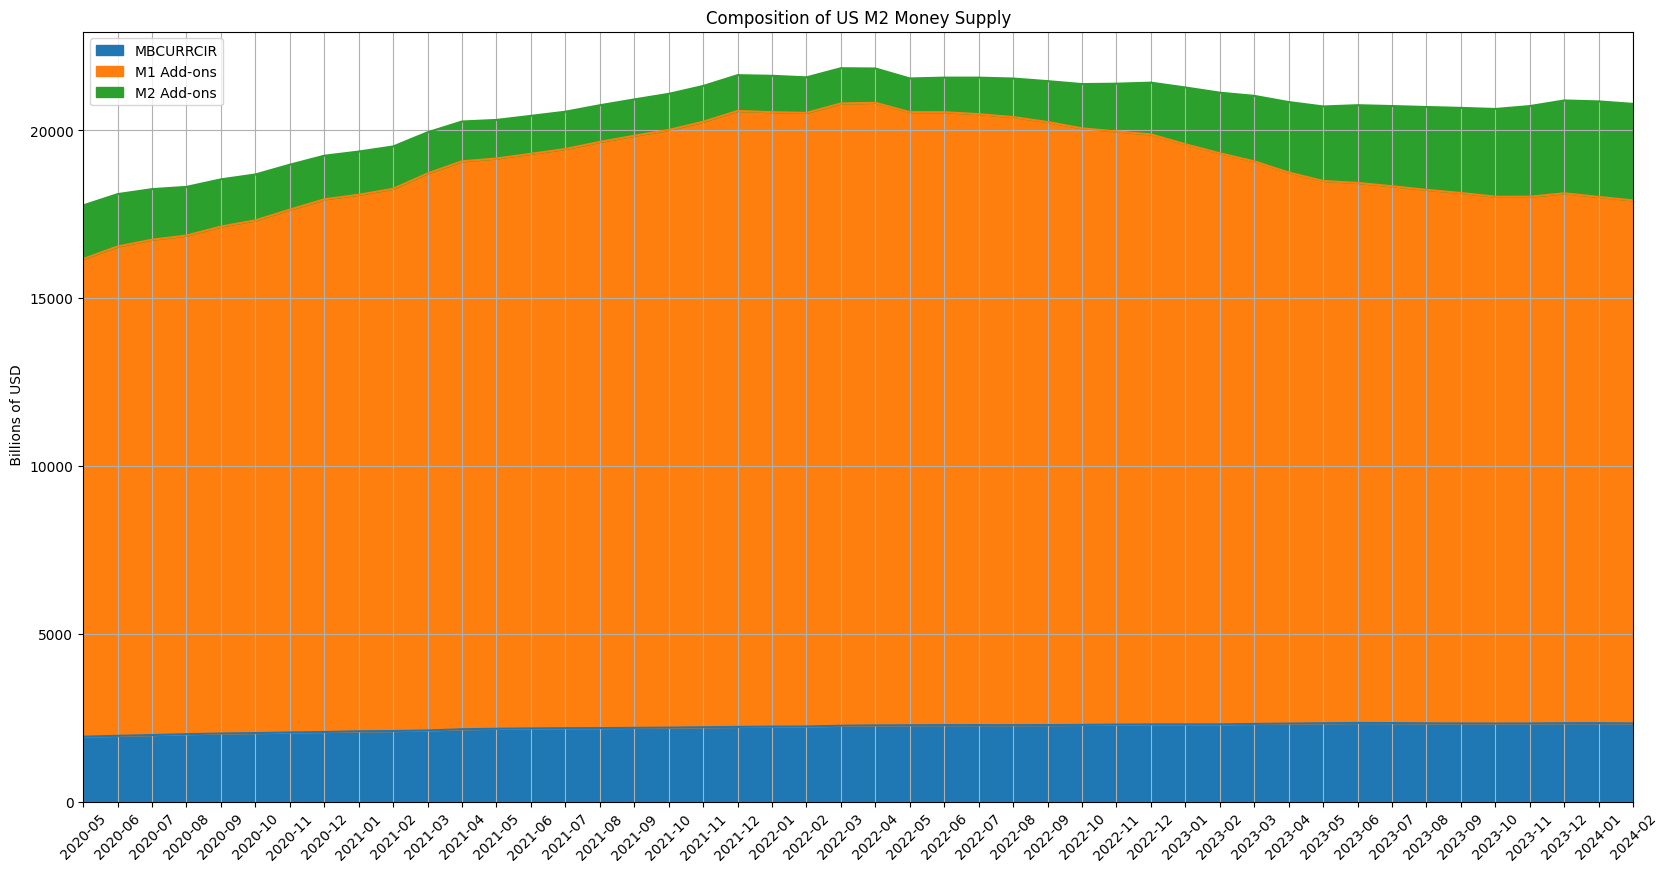

In [35]:
ax = m2_components.plot.area(figsize=(20,10), grid=True, title=M2_COMPOSITION_TITLE,
                             xticks=m2_components.index, xlabel='', rot=45,
                             ylabel=LEFT_Y_AXIS_LABEL)

_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, m2_components.index)))

In [42]:
idxmax = m2_total.idxmax()

print('Nominal M2 money supply maximum of {:>8.2f}bn reached in month {:%Y-%m}'
      .format(m2_total.loc[idxmax], idxmax))

print('Nominal M2 money supply shrank by {:>8.2f}bn since (as of month {:%Y-%m})'
      .format(m2_total.iloc[-1]-m2_total.loc[idxmax], m2_total.index[-1]))

print('Nominal M2 money supply changed by {:>8.2f}bn since {:%Y-%m} to {:.2f}bn'
      .format(m2_total.iloc[-1]-m2_total.iloc[-2], m2_total.index[-2], m2_total.iloc[-1]))

Nominal M2 money supply maximum of 21851.30bn reached in month 2022-03
Nominal M2 money supply shrank by -1063.70bn since (as of month 2024-02)
Nominal M2 money supply changed by   -74.90bn since 2024-01 to 20787.60bn


In [44]:
m2_components.iloc[-1, :] - m2_components.iloc[-2,:]

MBCURRCIR     -7.5
M1 Add-ons   -96.2
M2 Add-ons    28.8
dtype: float64

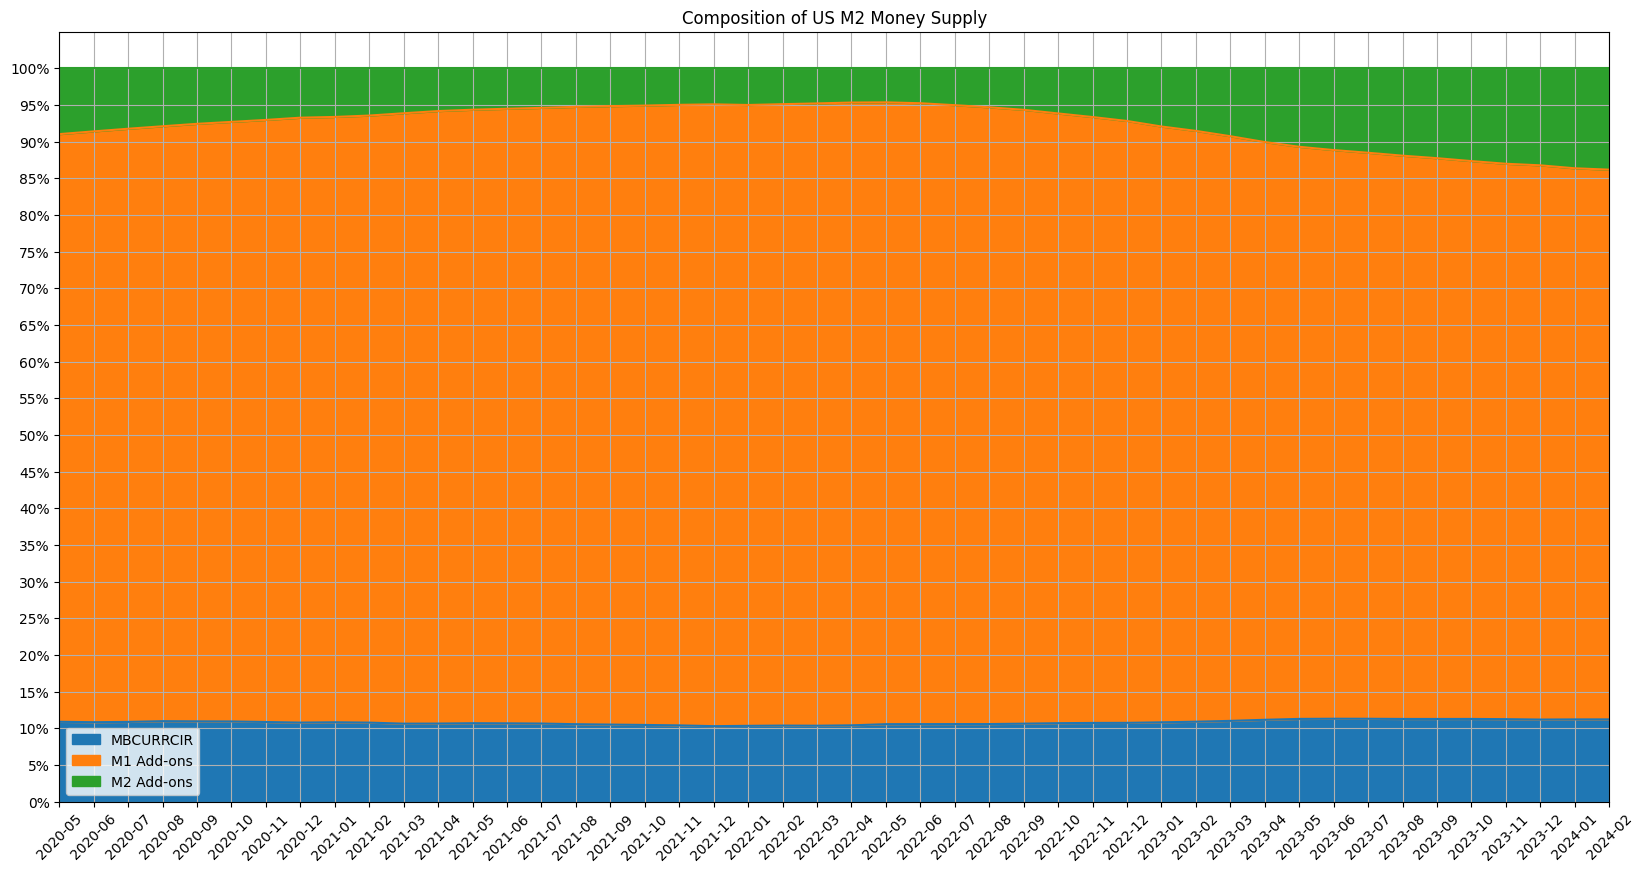

In [47]:
# Converting to percentages by dividing by total M2 Money Supply
# Dividing by the total M2 Money Supply
m2_components_pct = m2_components.divide(m2_total, axis=0)
m2_components_pct *= 100

ax = m2_components_pct.plot.area(figsize=(20,10), grid=True, title=M2_COMPOSITION_TITLE,
                              xticks=m2_components_pct.index, xlabel='', rot=45,
                              yticks=np.arange(0, 101, 5))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, m2_components_pct.index)))

In [53]:
m2_components_pct.iloc[-1,:] - m2_components_pct.iloc[-2,:]

MBCURRCIR     0.004277
M1 Add-ons   -0.191991
M2 Add-ons    0.187714
dtype: float64

In [54]:
m2_components_pct.iloc[-1,:]

MBCURRCIR     11.204757
M1 Add-ons    74.961034
M2 Add-ons    13.834209
Name: 2024-02-01 00:00:00, dtype: float64

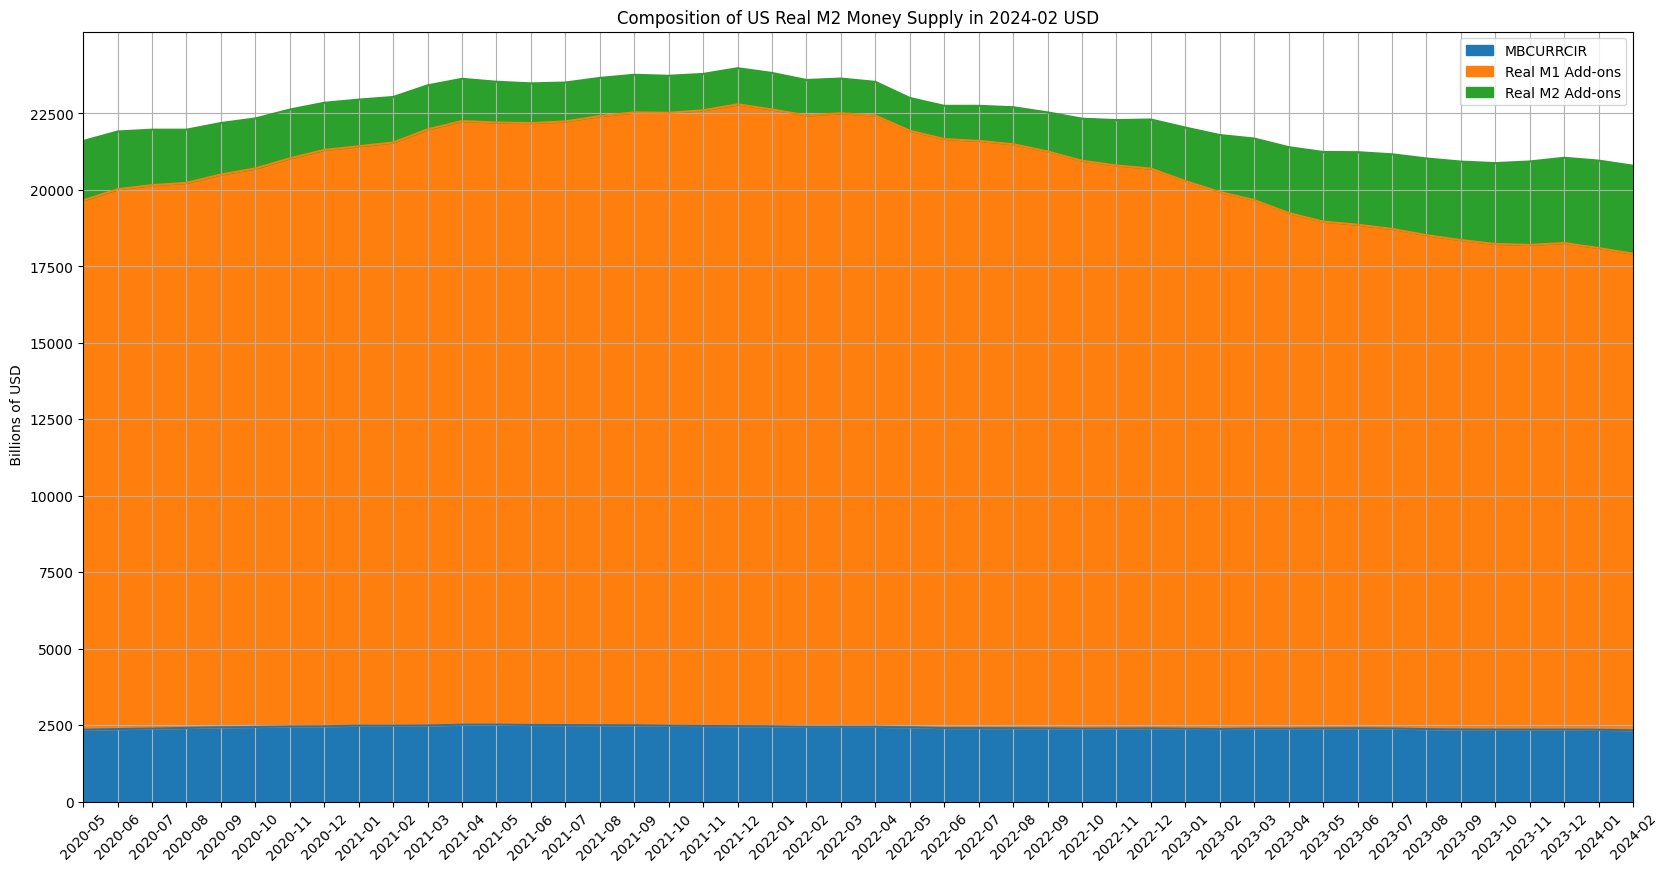

In [55]:
ax = m2real_components.plot.area(
    figsize=(20,10), grid=True,
    title=REALM2_COMPOSITION_TITLE + IN_USD_FORMATER.format(m2real_components.index[-1].date()),
    xticks=m2_components.index, xlabel='', rot=45,
    ylabel=LEFT_Y_AXIS_LABEL, yticks=np.arange(0, 25e3, 2.5e3)
)
_=ax.set_xticklabels(list(map('{:%Y-%m}'.format, m2real_components.index)))

In [58]:
idxmax = m2real_total.idxmax()
print('Real M2 money supply maximum of {:>8.2f}bn reached in month {:%Y-%m}'
      .format(m2real_total.loc[idxmax], idxmax))

print('Real M2 money supply shrank by {:>8.2f}bn since (as of month) {:%Y-%m})'
      .format(m2real_total.iloc[-1]-m2real_total.loc[idxmax], m2real_total.index[-1]))\

print('Real M2 money supply shrank by {:>8.2f}bn since {:%Y-%m} to {:.2f}bn'
      .format(m2real_total.iloc[-1]-m2real_total.iloc[-2], m2real_total.index[-2], m2real_total.iloc[-1]))

Real M2 money supply maximum of 23975.29bn reached in month 2021-12
Real M2 money supply shrank by -3187.69bn since (as of month) 2024-02)
Real M2 money supply shrank by  -167.13bn since 2024-01 to 20787.60bn
